## Feature Importance

from Notebook Filtering.ipynb after statistical Analyis, we continue this notebook with 5 dataframes :
**Original** dataframe as baseline for comparison. Contains 880 genera         
**uniques** unfiltered exclusive genera, contains 341 genera  
**uniques23** unfiltered exclusive genera plus common from categories 2 and 3, contains 773 genera      
**Influencers_OLS** filtered from original by threshold 0.2% abundance and frequency minimum of 3, selected genera using Ordinary Least Squares     
**OLS_all** selected data from the original underwent selection of significance by OLS.  
**uniques_OLS** selected from the original uniques Genera for each category were selected, posterior underwent selection of significance by OLS.   
**uniques_23_OLS** selected data from the original uniques Genera for each category, plus the common genera from category 2 and 3, posterior OLS.     
This notebook selects from original, uniques and uniques23 the 50 most influential features per pca analyis for the following df
**uniques_pca** from uniques after pca, made in this notebook, contains 51 genera      
**uniques23_pca** from uniques23 after pca contains        
**Influencers_uniques** from the mix of Influencers_OLS and uniques_OLS
  
Starting with 5 different df: OLS_all, Influencers_OLS, uniques_OLS, uniques_23_OLS, original apply the following pipelines
1. Apply Pipelines:
   * PCA visual scree plot and PCA scatterplot:
        These focus on the dimensionality reduction aspect and the structure of the data in the reduced space.  
   * PCA  Feature Influence , explained variance
     This focuses on how each feature contributes to the variance explained by the principal components.
   * Random Forest Regression- Feature importance
   * Random Forest Classification- Feature importance
2. Visually comparing Feature Importances and Influences:
   * Extract feature importances from the Random Forest models. 
     This focuses on the predictive power of each feature in the context of a Random Forest model
   * Extract feature influences from the PCA pipeline.
3. Replace IDs/GIDs with Biological Names:
   * Map the feature IDs to their corresponding biological names.
   * Analyze the biological significance of the selected features. For each dataframe and see if they make sense.
4. Combine and Select Most Influential Features:
   * Combine the results from different pipelines according to importance, influence and frequency into a DataFrame.
   * Select the top influential features

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from IPython.display import display, HTML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight  
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [213]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
original  = pd.read_excel('data/original.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques   = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques23 = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques23', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_OLS = pd.read_excel('data/uniques_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques23_OLS = pd.read_excel('data/uniques23_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [214]:
def clean_dataframe(df):
    return (df.drop(columns='Unnamed: 0', axis=1)
        .astype({'Sites': str, 'Category': int})
        .set_index("Sites"))

original = clean_dataframe(original)
uniques = clean_dataframe(uniques)
uniques23 = clean_dataframe(uniques23)
OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
uniques_OLS= clean_dataframe(uniques_OLS)
uniques23_OLS= clean_dataframe(uniques23_OLS)

### PCA explained_variance_ratio -Screeplot and PCA plot

In [215]:
def prepare_data(df, category_column, index_column=None):
    df_prepared = df.copy()
    if index_column:
        df_prepared = df_prepared.set_index(index_column)
    category = df_prepared[category_column]
    df_prepared = df_prepared.drop(columns=[category_column], axis=1)
    return df_prepared, category

def standardize_data(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return pd.DataFrame(X_scaled, columns=df.columns)

def perform_pca(X_scaled, n_components=None):
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(7, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(title) # "Explained Variance Ratio by Principal Components"
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X_pca, category, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Category'] = category.values
    colors = ['green', 'orange', 'red']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)
    plt.title(title)# "Data Points in Reduced Dimensional Space (PCA)"
    plt.show()

def pca_pipeline(df, category_column, index_column=None, n_components=None, dataset_name=None):
    df_prepared, category = prepare_data(df, category_column, index_column)
    X_scaled = standardize_data(df_prepared)

    # Perform PCA with all components for scree plot
    pca_all = PCA()
    pca_all.fit(X_scaled)
    explained_variance_ratio = pca_all.explained_variance_ratio_
    
    # Perform PCA with selected components for visualization
    pca, X_pca, explained_variance_ratio, cumulative_variance_ratio = perform_pca(X_scaled, n_components)
    
    if dataset_name:
        plot_scree(pca_all, f"Scree Plot for {dataset_name}")
        plot_pca_2d(X_pca, category, f"PCA 2D Visualization for {dataset_name}")
    
    results = {
        'pca': pca,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'X_pca': X_pca
    }
    return results

### PCA Feature Importance and Explained Variance by Original Feature

In [216]:
def apply_pipeline_pca(df, dataset_name, n_components, n_top_features=20):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target - STORE ORIGINAL COLUMN NAMES
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
                    
    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_
    
    # Get the loadings from the PCA object
    loadings = pca_pipeline.named_steps['pca'].components_
    
    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)
    
    # Create DataFrame with feature influences using original feature names
    df_pca_influence = pd.DataFrame({
        'Features':  feature_names,
        'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False)

    # Limit the DataFrame to the top n_top_features
    df_pca_influence = df_pca_influence.head(n_top_features)

   # Explained variance by original feature
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained Variance Ratio':  pca_pipeline.named_steps['pca'].explained_variance_ratio_
    }).head(25)
    
    return pca_pipeline, df_pca_influence, explained_variance, n_components

### Diplaying the Results

In [217]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

### Computing PCA and Varianza -Scree Plots for Original
Original dataframe as baseline for comparison

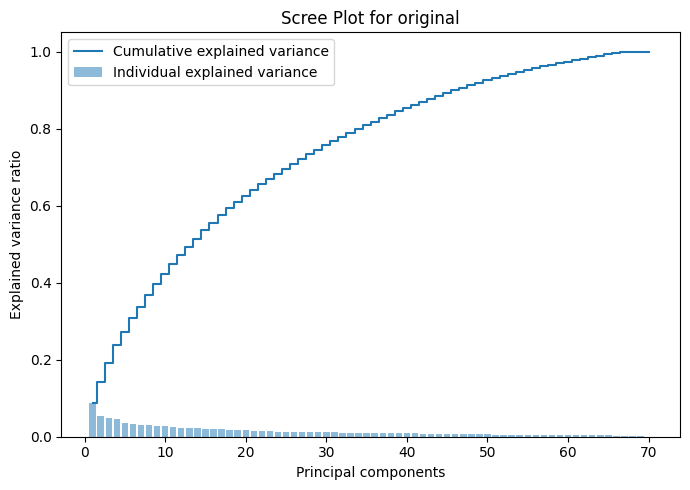

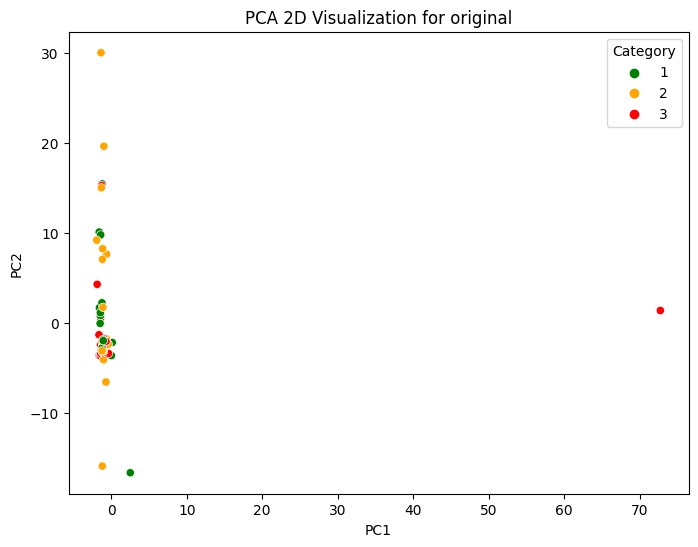

original_pipeline:


,Features,Influence
139,140,1.5668
574,575,1.5638
686,687,1.5264
464,465,1.5239
299,300,1.5232
528,529,1.5219
608,609,1.5073
563,564,1.4963
249,250,1.4956
473,474,1.4894


In [218]:
# Aply pipeline for visual results
original_pca = pca_pipeline(original, 'Category', n_components=2, dataset_name='original')

# Apply the pipeline for numerical results
original_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(original, "original", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

In [219]:
print(*df_pca_influence["Features"].values.tolist())

140 575 687 465 300 529 609 564 250 474 491 96 727 81 566 621 145 526 86 456 323 13 265 875 720 591 270 546 413 39 194 607 512 543 455 187 662 736 606 389 127 44 155 503 41 236 542 259 516 289


**original**:
   - original shows no aglomeration nor useful information which is expected the noise due to the large amount of data and features/sample ratio. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named original_pca and is composed of 51 features.

In [220]:
df_pca_influence_columns = df_pca_influence["Features"].values.tolist()
original_pca = original[["Category"] + df_pca_influence_columns]  

### Computing PCA and Varianza -Scree Plots for uniques
selected data from the original only unique genera per category is in this dataframe of 343 genera.

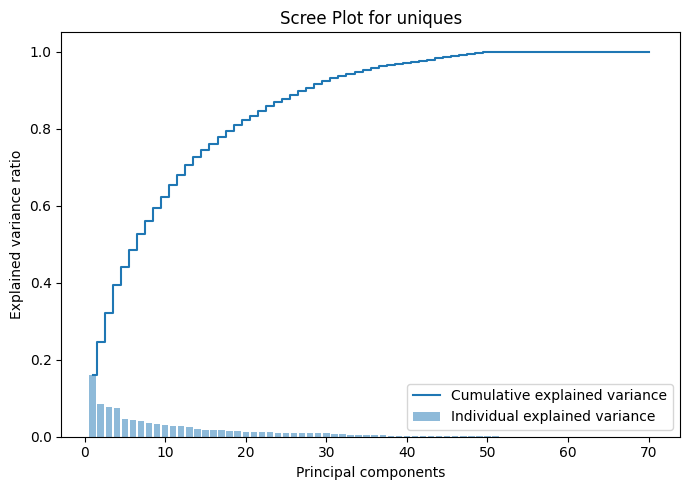

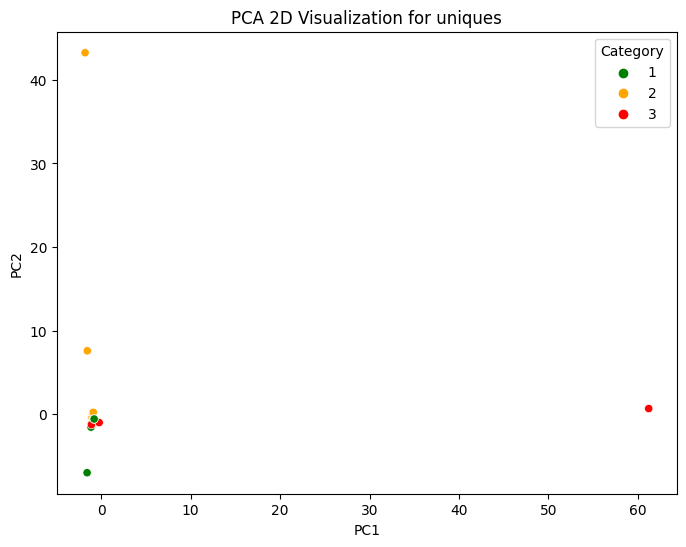

uniques_pipeline:


,Features,Influence
243,704,1.6067
36,87,1.6067
86,238,1.6065
148,442,1.6056
224,649,1.5352
73,201,1.4858
77,211,1.4858
233,680,1.4826
237,690,1.4072
201,578,1.3929


In [221]:
# Aply pipeline for visual results
uniques_pca = pca_pipeline(uniques, 'Category', n_components=2, dataset_name='uniques')

# Apply the pipeline for numerical results
uniques_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques, "uniques", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**uniques**
The explained variance improves referent to original df but the pca plot show very little diferenciation. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques_pca and is composed of 51 features.

In [222]:
# print the genera from this pca to check
#print(f"Genera uniques : {df_pca_influence['Features'].values.tolist()}")
print(*df_pca_influence['Features'].values.tolist())

704 87 238 442 649 201 211 680 690 578 621 160 696 190 457 361 594 396 240 123 857 85 494 558 132 635 436 410 477 427 46 399 244 571 122 698 22 287 239 576 382 856 406 412 645 872 104 225 636 78


In [223]:
df_pca_influence_columns = df_pca_influence["Features"].values.tolist()
uniques_pca = uniques[["Category"] + df_pca_influence_columns]  

In [224]:
uniques_pca.head()

,Category,704,87,238,442,649,201,211,680,690,...,382,856,406,412,645,872,104,225,636,78
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_4,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0022,0.0066,0.0044,0.0022,0.0000
site_5,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Computing PCA and Varianza -Scree Plots for uniques23
selected data from the original only unique genera per category is in this dataframe plus the common genera between 2 and 3 categories, contains 771 genera.

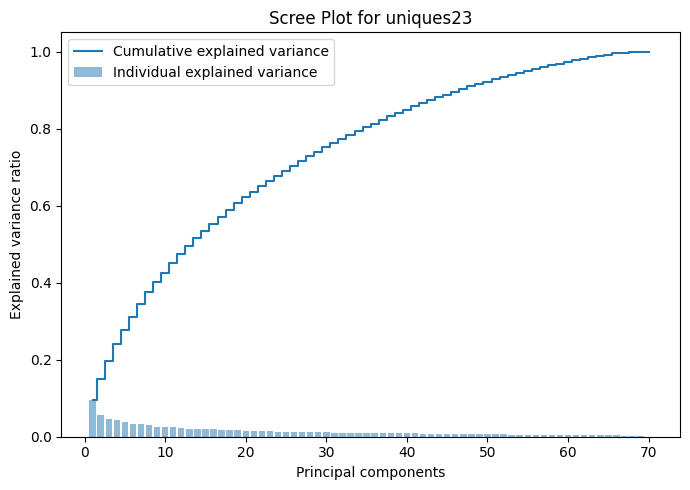

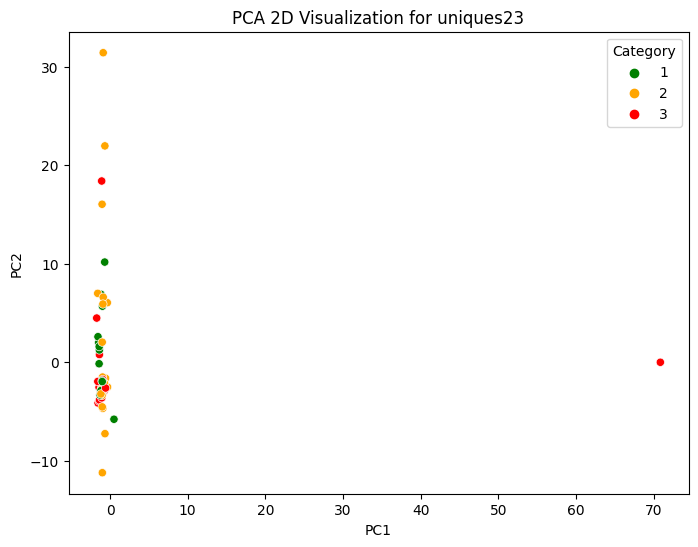

uniques23_pipeline:


,Features,Influence
203,236,1.7136
223,259,1.7136
476,542,1.7136
34,41,1.7136
165,194,1.6709
496,566,1.6660
405,465,1.6643
450,512,1.6622
250,289,1.6473
278,323,1.6459


In [225]:
# Aply pipeline for visual results
uniques23_pca = pca_pipeline(uniques23, 'Category', n_components=2, dataset_name='uniques23')

# Apply the pipeline for numerical results
uniques23_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques23, "uniques23", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**uniques23**
The explained variance is worse than uniques df and the pca plot show very little diferenciation. Notive that some influencer genera that are in original_pca are also on unique_pca. The first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques23_pca and is composed of 51 features.

In [226]:
print(*df_pca_influence["Features"].values.tolist())

236 259 542 41 194 566 465 512 289 323 127 110 358 621 270 330 687 720 284 265 529 456 634 276 250 140 497 214 413 139 300 223 655 243 606 575 607 81 552 591 44 39 389 86 108 526 195 308 343 614


In [227]:
df_pca_influence_columns = df_pca_influence["Features"].values.tolist()
uniques23_pca = uniques23[["Category"] + df_pca_influence_columns] 

### Computing PCA and Varianza -Scree Plots for Influencers_OLS
selected data from the original with abundance threshold of 0,2% and frequency of 3, underwent selection of significance by OLS

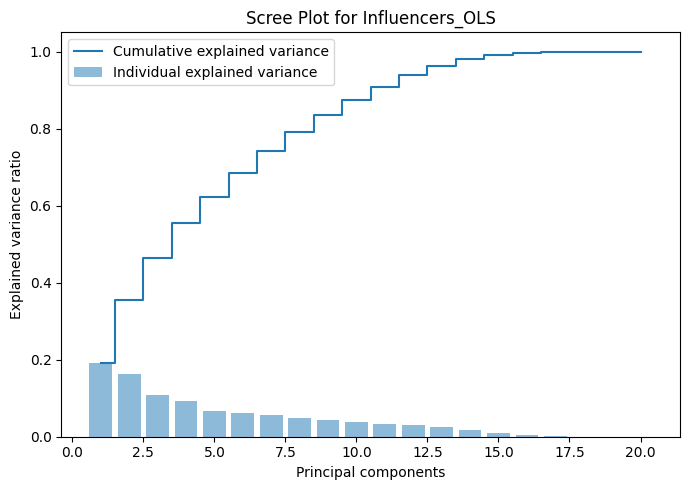

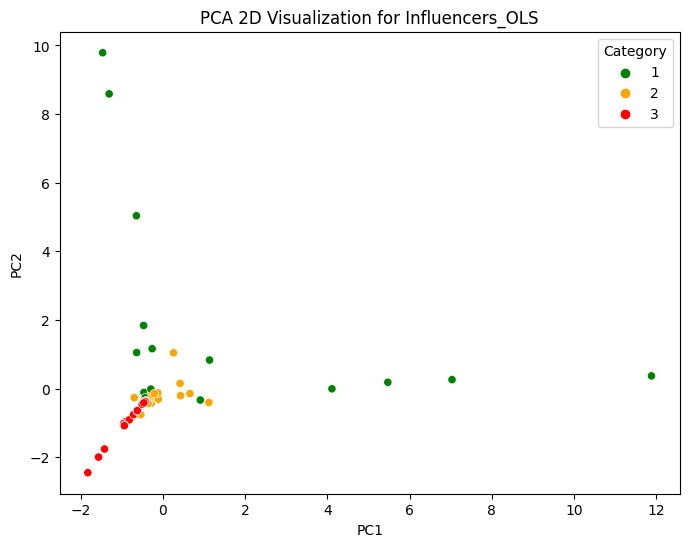

Influencers_OLS_pipeline:


,Features,Influence
14,408,2.9940
7,526,2.7758
3,351,2.7268
18,471,2.6385
8,584,2.4949
17,375,2.3507
5,91,2.2462
12,678,2.2045
15,334,2.0886
6,863,2.0526


In [228]:
# Aply pipeline for visual results
Influencers_OLS_pca = pca_pipeline(Influencers_OLS, 'Category', n_components=2, dataset_name='Influencers_OLS')
# Apply the pipeline for numerical results
Influencers_OLS_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Influencers_OLS, "Influencers_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**Influencers_OLS**:
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and 1. 
   - Category 3 There is a clear regression trend in category 3 
   - Category 2 dots align in the middle, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'v' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories.  

__Scree Plots:__ The Influencers_OLS dataset appears to decrease its explained variance more steeply compared to the OLS_all dataset.

### Computing PCA and Varianza -Scree Plots for OLS_all
selected data from the original underwent selection of significance by OLS.

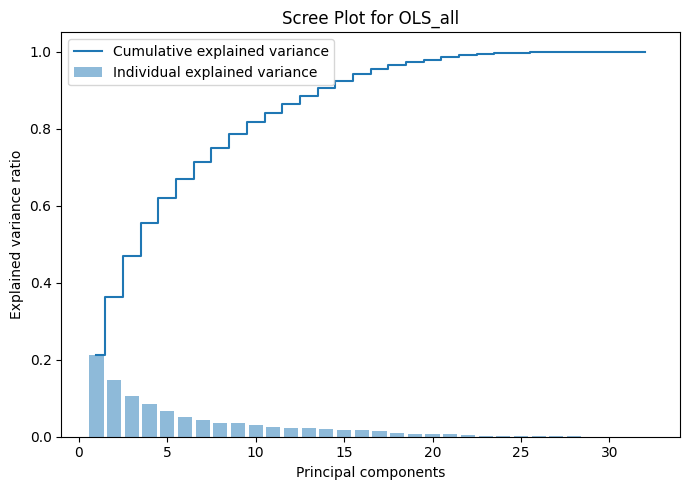

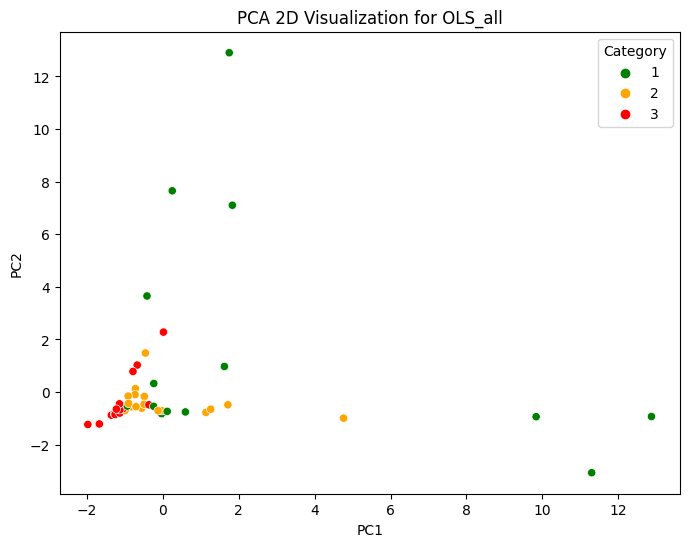

OLS_all_pipeline:


,Features,Influence
31,229,2.4905
7,91,2.4232
26,334,2.4185
4,470,2.2937
3,214,2.2573
17,494,2.1636
10,584,2.1621
25,92,2.1547
15,337,1.8287
27,140,1.7922


In [229]:
# Aply pipeline for visual results
OLS_all_pca = pca_pipeline(OLS_all, 'Category', n_components=2, dataset_name='OLS_all')
# Apply the pipeline for numerical results
OLS_all_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(OLS_all, "OLS_all", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**OLS_all**:
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.

In both scree plots, OLS_all and Influencers_OLS a clear "elbow point" is observed around the 5th principal component. This suggests that retaining the first 5 components captures a significant portion of the variance in the data. However, Influencers_OLS seems to achieve a higher explanatory power with fewer features compared to OLS_all, moreover the differentiation on the labels makes this dataset more relevant. According to the principle of parsimony or Occam's Razor, which states that among competing hypotheses, the one with the fewest assumptions should be selected, in this case Influencers_OLS. Until the biological significance is not accounted for, the datasets are to be retained for comparison.

### Computing PCA and Varianza -Scree Plots for uniques_OLS
selected data from the original only Genera samples that do no share category were selected, posterior underwent selection of significance by OLS.

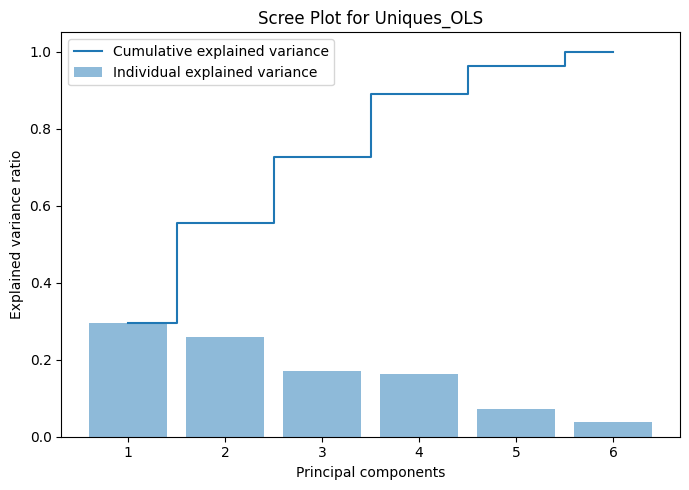

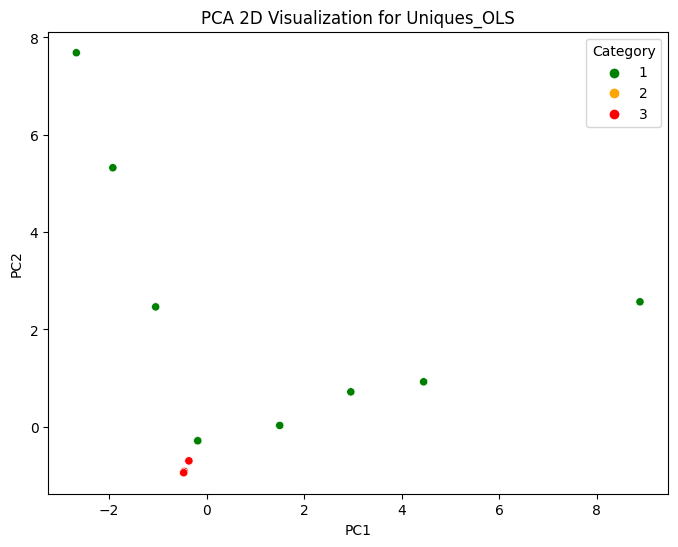

Uniques_OLS_pipeline:


,Features,Influence
0,541,1.7063
1,494,1.6987
2,201,1.4997
4,410,1.4997
5,799,1.0094
3,342,0.9827
,Component,Explained Variance Ratio
0,1,0.2935
1,2,0.2711
2,3,0.1697


In [230]:
# Aply pipeline for visual results
uniques_OLS_pca = pca_pipeline(uniques_OLS, 'Category', n_components=2, dataset_name='Uniques_OLS')
# Apply the pipeline for numerical results
uniques_OLS_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques_OLS, "Uniques_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**uniques_OLS**:
   - Uniques_OLS is compound of only 6 features and interestingly it shows the best differenciation on the pca of the components. Also the varianza increases from 0.2 on the previous dfs to 0.3 explained variance. Showing that this features can explain better the dataset in reference to the corrosion rick label. 
   - The v shape of the category 1 is very clear and so is the lineal presence of category 3.  

### Computing PCA and Varianza -Scree Plots for uniques_23_OLS
selected data from the original only Genera samples that do no share category were selected, plus the common genera from category 2 and 3, posterior underwent selection of significance by OLS.

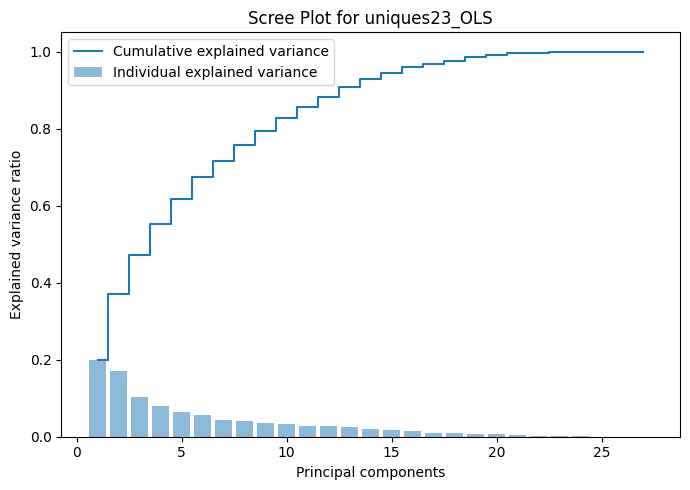

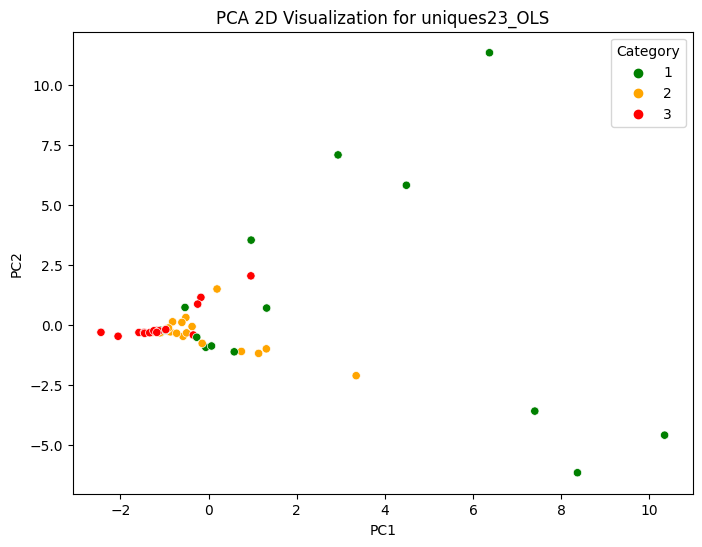

uniques23_OLS_pipeline:


,Features,Influence
26,229,2.5147
6,91,2.4703
4,470,2.3543
22,334,2.3338
3,214,2.2134
9,584,2.1912
13,337,2.1693
18,678,2.0656
11,799,1.9529
15,494,1.8830


In [231]:
# Aply pipeline for visual results
uniques23_OLS_pca = pca_pipeline(uniques23_OLS, 'Category', n_components=2, dataset_name='uniques23_OLS')
# Apply the pipeline for numerical results
uniques23_OLS_pca_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(uniques23_OLS, "uniques23_OLS", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

**unique_23__OLS**:
   - Uniques_23 is compose of more as 300 features and interestingly shows the worst differenciation blobs on the pca components. Also the varianza decreases from 0.3 on the previous df to 0.2 explained variance. Showing that this features have to be decreased in order to increase significance in reference to the corrosion rick label. 
   - Category 1 has very clear separation similar to the previous dataframes, however 2 and 3 are overlaped yet feature 3 continues to present a lineal regresion between the two PC.

### Pipeline for Regression

In [232]:
def apply_pipeline_regressor(df, dataset_name):
    print(f"{dataset_name}_pipeline:")
    '''
    Pipeline for regression that handles the imbalanced data
    '''
    
    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()
    
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)
    
    # Separate features and target Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Compute sample weights for the entire training set
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rf_mae_scores = []
    
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    for train_index, val_index in kf.split(X_train):
        # Split the current fold's train and validation sets
        X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        
        # Compute sample weights for the current fold
        fold_weights = compute_sample_weight(class_weight='balanced', y=y_train_fold)
        
        # Train and predict with sample weights
        rf_pipeline.fit(X_train_fold, y_train_fold, rf__sample_weight=fold_weights)
        y_pred = rf_pipeline.predict(X_val)
        
        # Calculate and store MAE
        mae = mean_absolute_error(y_val, y_pred).round(4)
        rf_mae_scores.append(mae)
    
    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {np.mean(rf_mae_scores).round(4)}")
    
    # Evaluate on the initial test split with sample weights
    rf_pipeline.fit(X_train, y_train, rf__sample_weight=sample_weights)
    y_test_pred = rf_pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_test_pred).round(4)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = mean_absolute_error(y_test, y_test_pred).round(4)
    print(f'Mean Absolute Error: {mae}')
    
    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(f'Feature Importance by RF: {df_importances_rf.head(25)}')
    
    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

### Pipeline for Clasification

In [233]:
def apply_classification_pipeline_classif(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()
    
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target  Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # Reshape target variables for consistency
    y_train = y_train.values
    y_test = y_test.values 

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize lists to store performance metrics
    cv_accuracy_scores = []
    cv_precision_scores = []
    cv_recall_scores = []
    cv_f1_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            class_weight=class_weight_dict  # Use computed class weights
        ))
    ])
    
    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        # Split training data
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Fit pipeline on training fold
        rf_pipeline.fit(X_fold_train, y_fold_train)
    
        # Predict on validation fold
        y_pred = rf_pipeline.predict(X_fold_val)
    
        # Calculate and store performance metrics
        cv_accuracy_scores.append(accuracy_score(y_fold_val, y_pred).round(4))
        cv_precision_scores.append(precision_score(y_fold_val, y_pred, average='weighted').round(4))
        cv_recall_scores.append(recall_score(y_fold_val, y_pred, average='weighted').round(4))
        cv_f1_scores.append(f1_score(y_fold_val, y_pred, average='weighted').round(4))

    # Print cross-validation results
    print("Cross-Validation Metrics:")
    print(f"Accuracy: {cv_accuracy_scores}")
    print(f"Average Accuracy: {np.mean(cv_accuracy_scores).round(4)}")
    print(f"Precision: {cv_precision_scores}")
    print(f"Average Precision: {np.mean(cv_precision_scores).round(4)}")
    print(f"Recall: {cv_recall_scores}")
    print(f"Average Recall: {np.mean(cv_recall_scores).round(4)}")
    print(f"F1-Score: {cv_f1_scores}")
    print(f"Average F1-Score: {np.mean(cv_f1_scores).round(4)}")

    # Final model fit on entire training data
    rf_pipeline.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = rf_pipeline.predict(X_test)

    # Confusion Matrix and Classification Report
    print("\nTest Set Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Extract feature importances
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create feature importance DataFrame
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print('\nFeature Importance:')
    print(df_importances_rf)
          
    return rf_pipeline, df_importances_rf

In [234]:
# Apply pipeline Regression
original_pca_pipeline_reg, df_importances_reg= apply_pipeline_regressor(original_pca, "original_pca")
# Apply the pipeline Classification
original_pca_pipe_class, df_importances = apply_classification_pipeline_classif(original_pca, "original_pca")

original_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6808, 0.9522, 0.5943, 0.4395, 0.7379]
Average MAE for RF: 0.6809
Mean Squared Error: 0.36
Root Mean Squared Error: 0.6
Mean Absolute Error: 0.4956
Feature Importance by RF:     Features  Importance
0        140      0.1133
17       526      0.1003
26       270      0.0916
20       323      0.0790
14       566      0.0741
10       491      0.0739
1        575      0.0572
12       727      0.0482
19       456      0.0357
9        474      0.0344
5        529      0.0342
25       591      0.0311
2        687      0.0309
34       455      0.0261
13        81      0.0192
18        86      0.0167
22       265      0.0166
42       155      0.0128
7        564      0.0123
31       607      0.0111
23       875      0.0094
4        300      0.0093
6        609      0.0087
38       606      0.0083
43       503      0.0079
original_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average Accuracy: 0.5349
Precision: [0.4826, 0.202, 0.6818, 0.3961, 0.5818]
Average Precision: 0.4689
Recall: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average Recall: 0.5349
F1-Score: [0.511, 0.2597, 0.6508, 0.4589, 0.5424]
Average F1-Score: 0.4846

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.50      0.57      0.53         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.49      0.50      0.49        14


Feature Importance:
    Features  Importance
17       526      0.0886
10       491      0.0844
20       323      0.0772
1        575      0.0622
26       270      0.0584
2        687      0.0512
12   

**Original_PCA_pipeline Regression**:
This pipeline shows moderate performance in regression and classification tasks. The Mean Absolute Error (MAE) is around 0.6756, with an average accuracy of 0.4571. The feature importance is distributed across multiple features, with features 323, 491, and 526 being the most significant. This pipeline does not seem to offer significant improvements over the existing pipelines.
**Original_pca_pipeline Classification**
Low cross-validation accuracy (0.4571) and inconsistent performance.
Class 1: Zero precision and recall, indicating an inability to classify this category.This pipeline is weaker than all of the others.

In [235]:
# Apply pipeline Regression
uniques_pca_pipeline_reg, df_importances_reg= apply_pipeline_regressor(uniques_pca, "uniques_pca")
# Apply the pipeline Classification
uniques_pca_pipe_class, df_importances = apply_classification_pipeline_classif(uniques_pca, "uniques_pca")

uniques_pca_pipeline:


Cross-Validation MAE Scores for RF: [0.5408, 0.7019, 0.4957, 0.3486, 0.6769]
Average MAE for RF: 0.5528
Mean Squared Error: 0.4413
Root Mean Squared Error: 0.6643
Mean Absolute Error: 0.4801
Feature Importance by RF:    Features  Importance
9       578      0.1765
22      494      0.1555
7       680      0.1222
5       201      0.0893
6       211      0.0690
0       704      0.0616
1        87      0.0574
23      558      0.0340
24      132      0.0339
4       649      0.0293
26      436      0.0266
25      635      0.0242
12      696      0.0196
43      412      0.0169
44      645      0.0126
11      160      0.0111
47      225      0.0098
10      621      0.0077
46      104      0.0076
45      872      0.0068
42      406      0.0065
2       238      0.0058
13      190      0.0041
48      636      0.0024
49       78      0.0021
uniques_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Metrics:
Accuracy: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average Accuracy: 0.5167
Precision: [0.8438, 0.5568, 0.8182, 0.8295, 0.8636]
Average Precision: 0.7824
Recall: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average Recall: 0.5167
F1-Score: [0.5822, 0.4897, 0.4242, 0.5449, 0.4779]
Average F1-Score: 0.5038

Test Set Evaluation:
Confusion Matrix:
[[3 0 0]
 [4 3 0]
 [3 0 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.30      1.00      0.46         3
           2       1.00      0.43      0.60         7
           3       1.00      0.25      0.40         4

    accuracy                           0.50        14
   macro avg       0.77      0.56      0.49        14
weighted avg       0.85      0.50      0.51        14


Feature Importance:
   Features  Importance
10      621      0.1156
2       238      0.0844
9       578      0.0666
49       78      0.0625
8       690      0.0570
31      399      0.0522
6       21

**uniques_PCA_pipeline Regression**:
Moderate average MAE (0.5302) but still higher than Influencers_OLS.
Feature importance concentrated on a few features (e.g., 418, 410, 578).This pipeline is slightly better than original_pca_pipeline but not as strong as Influencers_OLS.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5714) but class imbalance issues.
Class 1: Zero precision and recall.
Class 2: Moderate precision and high recall.
Class 3: Perfect precision and recall but limited support. This pipeline is slightly better than original_pca_pipeline but still has significant class imbalance issues.

In [236]:
# Apply pipeline Regression
uniques23_pca_pipeline_reg, df_importances_reg= apply_pipeline_regressor(uniques23_pca, "uniques23_pca")
# Apply the pipeline Classification
uniques23_pca_pipe_class, df_importances = apply_classification_pipeline_classif(uniques23_pca, "uniques23_pca")

uniques23_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6717, 0.8082, 0.4745, 0.3055, 0.6045]
Average MAE for RF: 0.5729
Mean Squared Error: 0.4196
Root Mean Squared Error: 0.6478
Mean Absolute Error: 0.5293
Feature Importance by RF:    Features  Importance
11      110      0.2010
25      140      0.1119
45      526      0.0788
5       566      0.0658
9       323      0.0650
14      270      0.0564
27      214      0.0518
21      456      0.0352
35      575      0.0331
16      687      0.0316
49      614      0.0309
29      139      0.0250
22      634      0.0239
37       81      0.0214
23      276      0.0199
39      591      0.0182
43       86      0.0151
18      284      0.0146
20      529      0.0134
34      606      0.0127
30      300      0.0088
36      607      0.0087
24      250      0.0079
19      265      0.0077
40       44      0.0062
uniques23_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Metrics:
Accuracy: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average Accuracy: 0.5333
Precision: [0.6448, 0.2273, 0.5, 0.7121, 0.4864]
Average Precision: 0.5141
Recall: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average Recall: 0.5333
F1-Score: [0.6377, 0.2797, 0.4394, 0.6228, 0.4646]
Average F1-Score: 0.4888

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 5 1]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.62      0.71      0.67         7
           3       0.67      0.50      0.57         4

    accuracy                           0.64        14
   macro avg       0.65      0.63      0.63        14
weighted avg       0.65      0.64      0.64        14


Feature Importance:
   Features  Importance
11      110      0.1098
45      526      0.1014
9       323      0.0762
29      139      0.0514
25      140      0.0505
49      614      0.0500
35      575  

**uniques_PCA_pipeline Regression**:
Higher average MAE (0.6247) and higher variability in MAE scores.
Feature importance distributed across multiple features. This pipeline does not offer significant improvements over the existing pipelines.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5286) with consistent but low accuracy across folds.
Class 1: Perfect precision but very low recall.
Class 2: Moderate precision and high recall.
Class 3: Zero precision and recall. This pipeline has similar issues to the other pipelines, particularly with class imbalance.

Analysing the three new created dfs from the pca dimensionality reduction step. We see that The uniques_pca_pipeline shows the lowest MAE, indicating it performs best in terms of prediction error. The uniques_pca_pipeline also has the highest accuracy.
Each pipeline has slightly different top features.
original_pca_pipeline top features: 42 323 (0.1183), 27 491 (0.0882)
uniques23_pca_pipeline top features: 11 323 (0.1204), 15 491 (0.0754)
uniques_pca_pipeline top features: 10 418 (0.1997), 34 410 (0.1751)

In [237]:
# Apply pipeline Regression
Influencers_pipeline_reg, Importances_rf_Influencers = apply_pipeline_regressor(Influencers_OLS, "Influencers_OLS")

# Apply the pipeline Classification
Influencers_pipe_class, importances_class_I = apply_classification_pipeline_classif(Influencers_OLS, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.3458, 0.2718, 0.1827, 0.1818, 0.1764]
Average MAE for RF: 0.2317
Mean Squared Error: 0.1712
Root Mean Squared Error: 0.4137
Mean Absolute Error: 0.2443
Feature Importance by RF:    Features  Importance
16      549      0.5054
7       526      0.1972
11      864      0.0650
6       863      0.0444
14      408      0.0386
2       214      0.0251
19      229      0.0234
5        91      0.0228
10      625      0.0160
13      565      0.0145
15      334      0.0137
3       351      0.0136
4        23      0.0124
17      375      0.0056
8       584      0.0019
18      471      0.0005
12      678      0.0000
0       725      0.0000
1       871      0.0000
9       712      0.0000
Influencers_OLS_pipeline:
Cross-Validation Metrics:
Accuracy: [0.9167, 0.9091, 0.8182, 0.8182, 0.8182]
Average Accuracy: 0.8561
Precision: [0.9306, 0.9242, 0.8701, 0.8701, 0.8182]
Average Precision: 0.8826
Recall: [0.9167, 0.9091, 0.8182, 0.8182, 0.8182

**Influencers_OLS Pipeline Regression:**
Cross-Validation MAE Scores for RF: Consistently lower and less variable (ranging from 0.1426 to 0.34) with a significantly lower average MAE (0.242).
Error Metrics:
MSE: 0.2618; RMSE: 0.5116; MAE: 0.34  

These metrics demonstrate improved prediction accuracy and model reliability compared to OLS_all. Feature importance is more concentrated, with feature 526 having an overwhelming impact (importance: 0.4318). Other features like 549 and 625 show noticeable contributions but to a lesser extent.

**Influencers_OLS_pipeline Classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.8286 (high and consistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but lower recall (misclassifications lead to only 67% recall).  
Class 2: High recall (100%) but lower precision (64%).   
Class 3: High precision (100%) but very low recall (25%), indicating many false negatives.  
Classification Report:  
Macro average recall (0.64) suggests unbalanced performance across classes.  
Weighted average metrics reflect an overall acceptable but not ideal model for classifying all categories equally well.  
Feature Importance:  
Feature 526 dominates (23.26%), followed by moderately impactful features like 549 and 864.  

In [238]:
# Apply pipeline Regression
OLS_all_pipe_reg, importances_reg_OLS = apply_pipeline_regressor(OLS_all, "OLS_all")

# Apply the pipeline classification
OLS_all_pipe_class, importances_class = apply_classification_pipeline_classif(OLS_all, "OLS_all")

OLS_all_pipeline:
Cross-Validation MAE Scores for RF: [0.7, 0.7109, 0.3736, 0.2518, 0.4764]
Average MAE for RF: 0.5025
Mean Squared Error: 0.3518
Root Mean Squared Error: 0.5931
Mean Absolute Error: 0.45
Feature Importance by RF:    Features  Importance
29      549      0.4051
6        23      0.0816
4       470      0.0703
3       214      0.0678
27      140      0.0678
31      229      0.0522
10      584      0.0452
14      625      0.0387
26      334      0.0242
1       871      0.0186
7        91      0.0179
23      565      0.0149
25       92      0.0139
22      605      0.0131
21      678      0.0126
0       725      0.0125
5        79      0.0071
8        88      0.0067
11      712      0.0067
24      426      0.0041
2       428      0.0040
9       480      0.0037
15      337      0.0036
30      771      0.0024
19      342      0.0019
OLS_all_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/pyth

Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average Accuracy: 0.553
Precision: [0.5278, 0.202, 0.3961, 0.4091, 0.6623]
Average Precision: 0.4395
Recall: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average Recall: 0.553
F1-Score: [0.553, 0.2597, 0.4589, 0.4615, 0.6685]
Average F1-Score: 0.4803

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
   Features  Importance
29      549      0.1605
3       214      0.1094
31      229      0.1005
6        23      0.0627
4       470      0.0526
27      140      0.0521
7        91   

**OLS_all_pipeline regression:**
Cross-Validation MAE Scores for RF: Higher variability across folds (ranging from 0.3935 to 0.6886) and a higher average MAE (0.5725) suggest that the model's predictive performance is less consistent.
Error Metrics:
Mean Squared Error (MSE): 0.3921; Root Mean Squared Error (RMSE): 0.6262;Mean Absolute Error (MAE): 0.5634
These metrics indicate lower prediction accuracy compared to the Influencers_OLS pipeline.
**Importance** is more evenly distributed, with no single feature dominating.
Top features (e.g., feature 549, 23, and 625) exhibit moderate importance values (0.1883, 0.1233, 0.0887).

**OLS_all_pipeline classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.4714 (significantly lower, inconsistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but extremely low recall (17%), with many false negatives.   
Class 2: Moderate precision (45%) and high recall (83%), indicating a focus on this class.  
Class 3: Zero precision and recall, indicating an inability to classify this category.  
Classification Report:   
Macro and weighted averages are much lower than Influencers_OLS, indicating an overall weaker model.  
Feature Importance:   
Importance is more distributed but lower overall contributions compared to Influencers_OLS.   

In [239]:
# Apply pipeline Regression
uniques_pipeline, importances_reg = apply_pipeline_regressor(uniques_OLS, "Uniques_OLS")
# Apply the pipeline Classification
uniques_pipe_class, importances_class = apply_classification_pipeline_classif(uniques_OLS, "unique_OLS")

Uniques_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.6302, 0.6662, 0.5366, 0.3111, 0.6006]
Average MAE for RF: 0.5489
Mean Squared Error: 0.4244
Root Mean Squared Error: 0.6515
Mean Absolute Error: 0.4848
Feature Importance by RF:   Features  Importance
0      541      0.3850
3      342      0.3199
2      201      0.2007
1      494      0.0626
5      799      0.0319
4      410      0.0000
unique_OLS_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Metrics:
Accuracy: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average Accuracy: 0.5364
Precision: [0.5227, 0.2066, 0.2066, 0.798, 0.4343]
Average Precision: 0.4336
Recall: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average Recall: 0.5364
F1-Score: [0.3938, 0.2841, 0.2841, 0.5974, 0.5065]
Average F1-Score: 0.4132

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 7 0]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.58      1.00      0.74         7
           3       1.00      0.25      0.40         4

    accuracy                           0.64        14
   macro avg       0.86      0.53      0.55        14
weighted avg       0.79      0.64      0.59        14


Feature Importance:
  Features  Importance
0      541      0.3192
3      342      0.2839
2      201      0.2149
1      494      0.1226
5      799      0.0595
4      410      0.0000


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**uniques_OLS_pipeline Regression:**
Cross-Validation MAE Scores for RF: Higher variability (range 0.3783–0.7313) and a comparable average MAE (0.572).  
Error Metrics:  
MSE: 0.7412 ; RMSE: 0.8609 ; MAE: 0.7313 (relatively high).  These metrics are slightly higher than those of the unique23 pipeline, suggesting a slightly higher level of error.
These metrics reflect suboptimal predictive performance compared to other datasets.  
Feature Importance:   
Importance is relatively concentrated among the top three features (541: 0.2426, 342: 0.2327, 410: 0.2050), suggesting a model reliant on a few key variables.  
**uniques_OLS_pipeline Classification:**
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.4286 to 0.7143, with an average accuracy of 0.5429. This is slightly better than the unique23 pipeline but still shows variability.
Confusion Matrix and Classification Report:
Class 1: Zero precision and recall, indicating all instances of this class are misclassified.
Class 2: Perfect precision and recall for the instances classified, but the confusion matrix suggests many instances are not classified correctly.
Class 3: Zero precision and recall, similar to Class 1.
Features 229 and 214 have the highest importance (0.1008 and 0.0947, respectively), followed by features 549, 23, and 140. Distribution similar to the uniques23.

In [240]:
# Apply pipeline Regression
unique_23_OLS_pipeline_rg, importances_rf_uniques23= apply_pipeline_regressor(uniques23_OLS, "unique23_OLS")
# Apply the pipeline Classification
# Apply the pipeline the working df
uniques23_pipe_class, importances_class_U = apply_classification_pipeline_classif(uniques23_OLS, "unique23_OLS")

unique23_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.7033, 0.7282, 0.3764, 0.2709, 0.5136]
Average MAE for RF: 0.5185
Mean Squared Error: 0.3634
Root Mean Squared Error: 0.6028
Mean Absolute Error: 0.4593
Feature Importance by RF:    Features  Importance
25      549      0.4159
4       470      0.0794
5        23      0.0774
24      140      0.0710
3       214      0.0699
26      229      0.0560
9       584      0.0409
12      625      0.0379
22      334      0.0244
1       871      0.0225
6        91      0.0171
20      565      0.0144
19      605      0.0128
18      678      0.0125
0       725      0.0102
21      426      0.0066
7        88      0.0065
2       428      0.0043
13      337      0.0042
10      712      0.0041
16      342      0.0037
8       480      0.0031
11      799      0.0022
14      541      0.0021
15      494      0.0009
unique23_OLS_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Metrics:
Accuracy: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average Accuracy: 0.5364
Precision: [0.4603, 0.202, 0.4667, 0.4091, 0.6364]
Average Precision: 0.4349
Recall: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average Recall: 0.5364
F1-Score: [0.4683, 0.2597, 0.5351, 0.4615, 0.6222]
Average F1-Score: 0.4694

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
   Features  Importance
25      549      0.1660
3       214      0.1063
26      229      0.0870
4       470      0.0743
24      140      0.0646
5        23      0.0620
6        91      

**unique_23_OLS_pipeline Regression**:
Cross-Validation MAE Scores for RF: Less variability (range 0.3867–0.72) and slightly higher average MAE (0.5751).
Error Metrics:
MSE: 0.3868 ; RMSE: 0.622 ; MAE: 0.5623 (lower than uniques_OLS).These metrics indicate better performance than uniques_OLS, possibly due to the model leveraging a larger pool of features.

**Feature importance** is more evenly distributed across top contributors (e.g., 549: 0.1899, 23: 0.1025, 625: 0.0889). High-dimensionality could contribute to complexity but might also capture subtle interactions.  
**unique_23_OLS_pipeline Classification**:
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.3571 to 0.5714, with an average accuracy of 0.4429. This indicates a moderate level of classification accuracy with significant variability.
Confusion Matrix and Classification Report:
Class 1: Perfect precision but very low recall (0.17), indicating many false negatives.
Class 2: Moderate precision (0.45) and high recall (0.83).
Class 3: Zero precision and recall, indicating all instances of this class are misclassified. Macro average recall is 0.33, suggesting unbalanced performance across classes.
Feature Importance:
Feature 229 has the highest importance (0.1008), followed by features 214, 549, 23, and 140. This indicates a spread of importance across several features.

**unique_23_OLS_pipeline** achieves slightly better predictive accuracy despite higher dimensionality, possibly due to capturing more complex interactions, performs better numerically. Suggesting that the dataset's complexity adds value despite reduced interpretability.
**uniques_OLS_pipeline**, though concise, has poorer error metrics, indicating potential underfitting or missing interactions and struggles with predictive accuracy.

### Analysing the models Regression and Classification. 
Both pipelines struggle with class imbalance, leading to poor performance on certain classes.
Feature importance is similar but with slight variations, suggesting that the same set of features is important for classification in both pipelines.

**Integrating Influencers_OLS and uniques_OLS**
So analysing the Influencers_OLS results it is seen that it clasify well class 1 and 3, however having fewer members of class 1, and uniques_OLS is a small dataframe that shows good classification on class 1. So the join of the two will be check. It is comprised of 27 genera.
**Integrating OLS_all and uniques_OLS**
This is likely better option because uniques_OLS has shown better performance in classifying Class 1, which is a weakness in OLS_all_pipeline. The feature importance distribution and the strengths in classifying Class 1 make it a good complement. However looking at the merge of the two of them, there is no need to join them since uniques is part of all. 

In [241]:
# Merging the dataframes OLS_all and uniques_OLS on idex "Sites
all_uniques= pd.merge(OLS_all, uniques_OLS, left_index=True, right_index=True, suffixes =('_all', '_uniques'))
# Drop any duplicate columns 
all_uniques= all_uniques.loc[:, ~all_uniques.columns.duplicated()]
all_uniques= all_uniques.drop(columns="Category_uniques")
all_uniques = all_uniques.rename(columns={"Category_all" : "Category"})
all_uniques.columns

Index(['Category', '725', '871', '428', '214', '470', '79', '23', '91', '88',
       '480', '584', '712', '90', '799_all', '625', '337', '541_all',
       '494_all', '657', '342_all', '410_all', '678', '605', '565', '426',
       '92', '334', '140', '201_all', '549', '771', '229', '541_uniques',
       '494_uniques', '201_uniques', '342_uniques', '410_uniques',
       '799_uniques'],
      dtype='object')

In [242]:
# Ensure that the Sites index is sorted properly
Influencers_OLS = Influencers_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
uniques_OLS = uniques_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))

In [243]:
# Merging the dataframes Influencers_OLS and uniques_OLS on idex "Sites
Influencers_uniques= pd.merge(Influencers_OLS, uniques_OLS, left_index=True, right_index=True, suffixes =('_Influencers', '_uniques'))
# Drop any duplicate columns 
Influencers_uniques= Influencers_uniques.loc[:, ~Influencers_uniques.columns.duplicated()]
Influencers_uniques= Influencers_uniques.drop(columns="Category_uniques")
Influencers_uniques = Influencers_uniques.rename(columns={"Category_Influencers" : "Category"})
Influencers_uniques = Influencers_uniques.reset_index()

In [244]:
Influencers_uniques = Influencers_uniques.astype({"Sites": str, "Category": int})
Influencers_uniques = Influencers_uniques.set_index("Sites")

In [245]:
Influencers_uniques.head()

,Category,725,871,214,351,23,91,863,526,584,...,549,375,471,229,541,494,201,342,410,799
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1508,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_10,2,0.0000,0.0000,0.0000,0.0000,0.0000,2.4200,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_11,3,0.0000,0.0000,0.9210,0.0000,0.0000,0.0000,0.0000,0.0767,0.0767,...,0.0000,0.0000,5.8839,11.9724,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_12,3,0.0000,0.0000,0.3021,0.0000,0.0000,0.0000,0.0000,0.0336,0.1188,...,0.0000,0.0000,1.1592,0.1394,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_13,3,0.0000,0.0000,0.6947,0.0000,0.0000,0.0000,0.0000,0.0000,0.0595,...,0.0000,0.0000,0.5558,0.8535,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


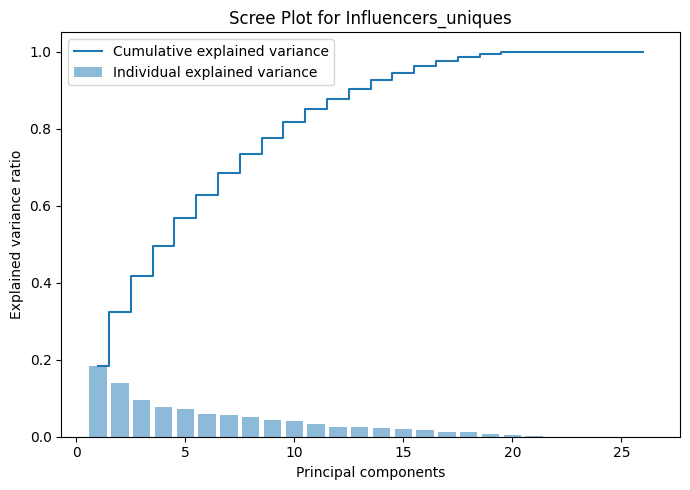

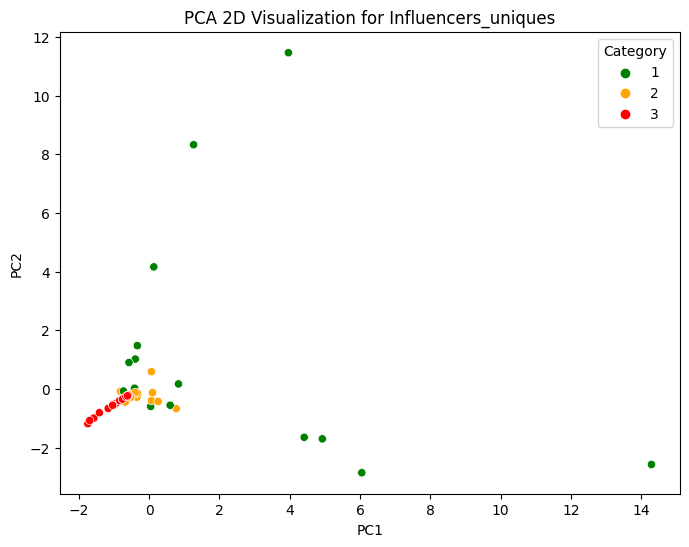

Influencers_uniques_pipeline:


,Features,Influence
3,351,2.7884
7,526,2.7823
8,584,2.6517
6,863,2.6188
5,91,2.5226
16,549,2.4494
11,864,2.4418
18,471,2.4326
14,408,2.4060
17,375,2.3493


Influencers_uniques_pipeline:
Cross-Validation MAE Scores for RF: [0.345, 0.2718, 0.1773, 0.1791, 0.1664]
Average MAE for RF: 0.2279
Mean Squared Error: 0.1715
Root Mean Squared Error: 0.4141
Mean Absolute Error: 0.2471
Feature Importance by RF:    Features  Importance
16      549      0.5109
7       526      0.1998
11      864      0.0651
6       863      0.0466
14      408      0.0360
19      229      0.0248
2       214      0.0243
4        23      0.0231
5        91      0.0209
3       351      0.0140
10      625      0.0138
13      565      0.0091
15      334      0.0085
18      471      0.0027
8       584      0.0003
22      201      0.0001
12      678      0.0000
17      375      0.0000
0       725      0.0000
1       871      0.0000
23      342      0.0000
21      494      0.0000
20      541      0.0000
24      410      0.0000
9       712      0.0000
Influencers_uniques_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.7273, 0.8182, 0.8182]
Average Accuracy: 0.821

In [246]:
# Aply pipeline for visual results
Influencers_uniques_pca = pca_pipeline(Influencers_uniques, 'Category', n_components=2, dataset_name='Influencers_uniques')

# Apply the pipeline for numerical results
Influencers_uniques_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Influencers_uniques, "Influencers_uniques", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
Influencers_uniques_pipeline_reg, importances_reg= apply_pipeline_regressor(Influencers_uniques, "Influencers_uniques")
# Apply the pipeline Classification
Influencers_uniques_pipe_class, importances_class = apply_classification_pipeline_classif(Influencers_uniques, "Influencers_uniques")

**Influencers_uniques pipeline Regression**:
The model is performing well with low MAE variability, ranging from 0.1415 to 0.3307 and an average MAE of 0.24. Compared to previous datasets (like uniques_OLS_pipeline where the variability was higher), this suggests an improved and more reliable model.
MSE (0.2523) and RMSE (0.5022) indicate moderate error levels, which suggest the model is performing reasonably well in terms of prediction accuracy. These are substantially better than earlier models where error levels were high.
**Feature importance** 
Feature 526 stands out as the most significant with an importance score of 0.4293, followed by feature 549 at 0.2017. These scores point to a few dominating features, which aligns with my future approach of combining the most influential features across datasets. This can potentially improve both feature selection and model generalization when merged. Indeed, the features indicate a focus on a few predictors that contribute heavily to the outcome. This could be useful when aim to reduce features but still retain biologically relevant ones.  
**Influencers_uniques_pipeline Classification**:
Cross-Validation Accuracy: This model achieved an average classification accuracy of 0.9571, which is quite strong. The relatively high accuracy, along with a well-balanced confusion matrix, suggests that the model can differentiate well across the three categories.  
Confusion Matrix & Classification Report:
    Class 1: Precision is perfect (1.0), but recall suffers (0.67), indicating that there may be a misclassification problem with certain examples.
    Class 2: High recall (1.0), but lower precision (0.78), meaning the model is good at catching all instances of Class 2 but sometimes incorrectly classifies other categories as Class 2.
    Class 3: Very high precision (1.0) but lower recall (0.75), indicating some false negatives are present, but the classification of class 3 is still accurate when it happens.

This classification model is performing fairly well but could be further refined, especially in terms of recall for classes 1 and 3, perhaps with tweaks in model parameters.

Feature Importance: The top three most important features (526, 549, and 864) once again highlight a few dominating predictors. These feature priorities would be the core of my focus, moving forward into the feature selection across datasets using biological relevance.

Influencers_uniques regression performance is improving with reduced error and a more concentrated feature importance distribution. This is promising for further refinement. The classification performance suggests some room for improvement, particularly in balancing recall and precision across classes, especially for Class 1 and 3. Combining datasets with influential features and considering their biological relevance for dimensionality reduction is an effective way forward.
Feature selection based on importance, variance, and biological significance will help ensure the model remains robust while simplifying feature sets.

SAVING COMBINED FEATURES 
The dataframes with a significant degree of importance for the next phase will be retained. Uniques_OLS has already been combined to create Influencers_uniques. The original features' PCA performance may provide valuable insights into predicting overall behavior and will be carried forward as original_pca. However, dataframes such as uniques_pca, uniques23_pca, uniques23_OLS, and original do not demonstrate notable contributions toward improving the models. As a result, they will be dropped in this notebook after extracting their three most important features. The dataframe OLS_all will undergo further processing in the subsequent steps.
In order to get the most important Features that make up the dfs that will be discarded, the dfs will be join together and passed through the pipelines of this notebook, then we will have another df "mergers"

original_pca  
Category 270 727 151 474 687 418 663 201 564 41 552 148 487 155 607 223 18 865 254 308 227 574 526 81 639 367 172 491 166 660 585 145 108 705 733 584 250 341 561 271 84 300 323 211 259 229 551 670 373 269  
uniques_pca    
Category 190 578 160 696 457 594 361 123 240 396 418 680 201 87 704 649 427 477 46 78 355 511 385 2 242 879 571 698 244 122 22 639 367 197 410 85 436 635 558 132 494 636 872 225 104 621 239 576 382 856  
uniques23_pca  
Category 270 41 526 172 865 151 300 18 552 487 474 323 663 687 108 491 148 574 250 86 373 535 245 127 308 561 214 276 660 155 455 563 330 269 575 81 254 484 551 271 607 194 140 709 566 529 497 572 389 200  
uniques23_OLS  
Category 725 871 428 214 470 23 91 88 480 584 712 799 625 337 541 494 342 410 678 605 565 426 334 201 140 549 229  
OLS_all   
Category 725 871 428 214 470 79 23 91 88 480 584 712 90 799 625 337 541 494 657 342 410 678 605 565 426 92 334 140 201 549 771 229  



In [247]:
# Colecting all columns names and ensure column names are all strings, strip and standardize)
original.columns = original.columns.astype(str).str.strip()  
original_pca_columns = [str(col).strip() for col in original_pca.columns.tolist()]
uniques_pca_columns = [str(col).strip() for col in uniques_pca.columns.tolist()]
uniques23_pca_columns = [str(col).strip() for col in uniques23_pca.columns.tolist()]
uniques23_OLS_columns = [str(col).strip() for col in uniques23_OLS.columns.tolist()]
OLS_all_columns = [str(col).strip() for col in OLS_all.columns.tolist()]

In [248]:
print(*f'OLS_all, OLS_all.columns.tolist()')
print(*Influencers_uniques.columns.tolist())

O L S _ a l l ,   O L S _ a l l . c o l u m n s . t o l i s t ( )
Category 725 871 214 351 23 91 863 526 584 712 625 864 678 565 408 334 549 375 471 229 541 494 201 342 410 799


In [249]:
# Combine and deduplicate
merged_columns = list(set(original_pca_columns + 
                          uniques_pca_columns + 
                          uniques23_pca_columns + 
                          uniques23_OLS_columns + 
                          OLS_all_columns))

# Filter only columns available in original
original_columns = [str(col) for col in original.columns.tolist()]  # Ensure consistency in data types
valid_columns = [col for col in merged_columns if col in original_columns]

# Extract data for these columns from the original dataframe
Merged_df = original[merged_columns]

# Verify results
#print(Merged_df.head())
print(f"Number of features in merged_df: {Merged_df.shape[1]}")

Number of features in merged_df: 145


In [250]:
print(*Merged_df.columns.tolist())

605 110 240 771 229 576 239 78 491 155 645 546 456 287 323 308 46 426 736 564 875 342 132 529 662 625 334 607 565 474 696 236 238 41 223 725 584 123 85 88 477 649 698 81 145 591 497 558 427 201 270 410 389 284 190 655 621 337 265 289 594 635 634 91 79 86 566 543 516 606 361 300 457 549 465 399 552 108 22 276 90 872 396 259 195 727 406 687 541 799 712 680 92 720 104 470 23 140 127 856 243 609 542 244 194 413 494 13 343 690 214 382 512 39 428 480 678 122 225 96 871 578 455 Category 503 187 704 412 657 442 571 330 139 250 575 436 358 87 636 211 160 44 857 614 526


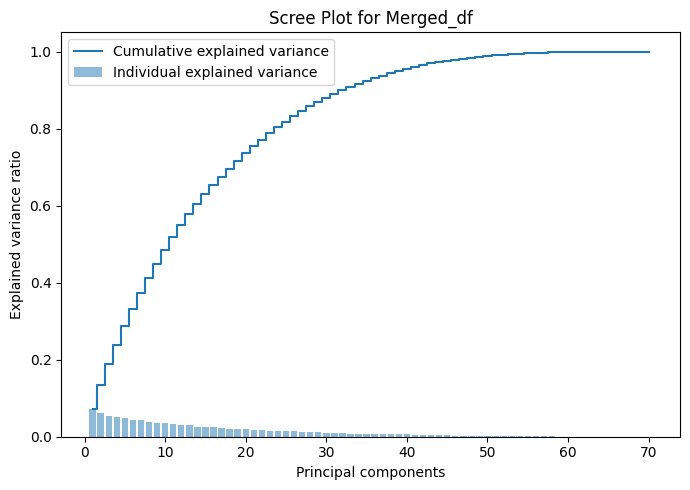

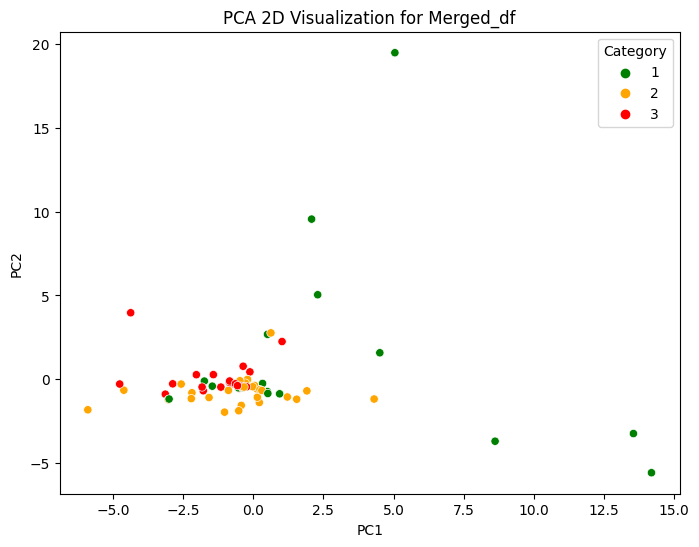

Merged_df_pipeline:


,Features,Influence
92,92,2.5162
23,529,2.4878
123,503,2.4237
36,584,2.4236
65,86,2.4212
8,491,2.3786
9,155,2.3168
89,799,2.2185
3,771,2.2185
143,526,2.1957


Merged_df_pipeline:
Cross-Validation MAE Scores for RF: [0.6875, 0.7673, 0.4882, 0.3091, 0.5809]
Average MAE for RF: 0.5666
Mean Squared Error: 0.2941
Root Mean Squared Error: 0.5423
Mean Absolute Error: 0.4236
Feature Importance by RF:     Features  Importance
73       549      0.3516
50       270      0.0521
1        110      0.0466
14       323      0.0464
95       470      0.0447
97       140      0.0444
143      526      0.0421
96        23      0.0270
110      214      0.0257
8        491      0.0233
66       566      0.0187
25       625      0.0181
26       334      0.0150
12       456      0.0137
132      250      0.0130
142      614      0.0130
62       634      0.0128
87       687      0.0113
122      455      0.0101
4        229      0.0090
23       529      0.0088
120      871      0.0079
123      503      0.0075
85       727      0.0075
58       265      0.0074
Merged_df_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Metrics:
Accuracy: [0.5833, 0.4545, 0.8182, 0.6364, 0.7273]
Average Accuracy: 0.6439
Precision: [0.5833, 0.2273, 0.8909, 0.7121, 0.7636]
Average Precision: 0.6354
Recall: [0.5833, 0.4545, 0.8182, 0.6364, 0.7273]
Average Recall: 0.6439
F1-Score: [0.5768, 0.303, 0.7955, 0.6228, 0.7273]
Average F1-Score: 0.6051

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.50      0.57      0.53         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.49      0.50      0.49        14


Feature Importance:
    Features  Importance
73       549      0.0904
110      214      0.0450
1        110      0.0434
143      526      0.0428
8        491      0.0394
..       ...         ...
117 

In [251]:
# Aply pipeline for visual results
Merged_df_pca = pca_pipeline(Merged_df, 'Category', n_components=2, dataset_name='Merged_df')

# Apply the pipeline for numerical results
Merged_df_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Merged_df, "Merged_df", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
Merged_df_pipeline_reg, importances_reg= apply_pipeline_regressor(Merged_df, "Merged_df")
# Apply the pipeline Classification
Merged_df_pipe_class, importances_class = apply_classification_pipeline_classif(Merged_df, "Merged_df")


**Merged_df pipeline Regression**: 
High variance in MAE scores: [0.8136, 0.5479, 0.3764, 0.3979, 0.5936]. Average MAE: 0.5459. This inconsistency suggests unstable model performance
Poor PCA plot and variance explanation could indicate a high dimensionality issues and or a lack of clear separation between classes
**Merged_df pipeline Classification**:
Consistent Cross-Validation Accuracy: 0.9286 (always the same) Suggests potential data leakage or overfitting. Indicates the model might not be truly generalizing
High precision and recall for most classes
Perfect accuracy for Class 1 and Class 2
Slightly lower performance for Class 3

### Feature Selection as a function of Influence and Importance

In [252]:
# Let's see what we're working with
print("PCA influence dataframe structure:")
print(df_pca_influence.head())
print("\nColumns:", df_pca_influence.columns)

print("\nRegression importance dataframe structure:")
print(importances_reg.head())
print("\nColumns:", importances_reg.columns)

print("\nClassification importance dataframe structure:")
print(importances_class.head())
print("\nColumns:", importances_class.columns)

PCA influence dataframe structure:
    Features  Influence
92        92     2.5162
23       529     2.4878
123      503     2.4237
36       584     2.4236
65        86     2.4212

Columns: Index(['Features', 'Influence'], dtype='object')

Regression importance dataframe structure:
   Features  Importance
73      549      0.3516
50      270      0.0521
1       110      0.0466
14      323      0.0464
95      470      0.0447

Columns: Index(['Features', 'Importance'], dtype='object')

Classification importance dataframe structure:
    Features  Importance
73       549      0.0904
110      214      0.0450
1        110      0.0434
143      526      0.0428
8        491      0.0394

Columns: Index(['Features', 'Importance'], dtype='object')


In [253]:
# For PCA - take second column as features and third as influence
pca_scores = pd.Series(df_pca_influence.iloc[:, 2].values,  # Influence values 
                      index=df_pca_influence.iloc[:, 1])     # Feature names

# For regression and classification - should be already properly formatted
reg_scores = importances_reg['Importance']
class_scores = importances_class['Importance']

# Normalize scores
pca_scores_norm = pca_scores / pca_scores.sum()
reg_scores_norm = reg_scores / reg_scores.sum()
class_scores_norm = class_scores / class_scores.sum()

# Create comparison dataframe
feature_comparison = pd.DataFrame({
    'PCA_Score': pca_scores_norm,
    'Regression_Score': reg_scores_norm,
    'Classification_Score': class_scores_norm
})
feature_comparison['Combined_Score'] = feature_comparison.mean(axis=1)

print("\nTop features across all methods:")
print(feature_comparison.sort_values('Combined_Score', ascending=False).head(15))

IndexError: single positional indexer is out-of-bounds

In [ ]:
# Scrutining Influence and importance
results = analyze_features(Merged_df, 'Category')

dataset_pipeline:
dataset_pipeline:
Cross-Validation MAE Scores for RF: [0.6875, 0.7673, 0.4882, 0.3091, 0.5809]
Average MAE for RF: 0.5666
Mean Squared Error: 0.2941
Root Mean Squared Error: 0.5423
Mean Absolute Error: 0.4236
Feature Importance by RF:     Features  Importance
73       549      0.3516
50       270      0.0521
1        110      0.0466
14       323      0.0464
95       470      0.0447
97       140      0.0444
143      526      0.0421
96        23      0.0270
110      214      0.0257
8        491      0.0233
66       566      0.0187
25       625      0.0181
26       334      0.0150
12       456      0.0137
132      250      0.0130
142      614      0.0130
62       634      0.0128
87       687      0.0113
122      455      0.0101
4        229      0.0090
23       529      0.0088
120      871      0.0079
123      503      0.0075
85       727      0.0075
58       265      0.0074


KeyError: 'FeaturesInfluence'

In [560]:
# Save multiple dataframes to different sheets in the same Excel file
with pd.ExcelWriter(f'data/df_after_pca.xlsx') as writer:
    original_pca.to_excel(writer, sheet_name='original_pca', index=True)
    Merged_df.to_excel(writer, sheet_name='merged_df', index=True)
    Influencers_uniques.to_excel(writer, sheet_name='Influencers_uniques', index=True)

## Comparison of the Feature Importance and Feature Influence
### Influencers_OLS, OLS_all and uniques_23 

In [561]:
# Create a function to display side-by-side
def display_side_by_side(*args, titles=()):
    """Display multiple DataFrames side-by-side."""
    html_str = '<div style="display:flex;">'
    for df, title in zip(args, titles):
        html_str += f'<div style="margin-right:20px;"><h3>{title}</h3>' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# Display the data side-by-side
display_side_by_side(df_pca_Influencers, Importances_rf_Influencers, df_pca_influence_OLS_all, importances_rf_OLS, df_pca_influence_uniques23, importances_rf_uniques23,  
                     titles=["PCA Influence influencers", "RF Feature Importance influencers", "PCA Influence OLS_all", "RF Feature Importance OLS_all",  "PCA Influence uniques_23", "RF Feature Importance uniques_23"])

NameError: name 'df_pca_influence_influencers' is not defined

### Manually prunning the features according to importance and influence

### Loop to iterate existent selected Genera 
Now I will make a loop to iterate the existing genera and iteratively replace just one to see which model perform better in order to prune more features

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Original selected GIDs
selected_gen_fin = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}
selected_gen_fin = set(map(str, selected_gen_fin))

mae_results = {}  # Initialize an empty dictionary to store MAE results

for gid_to_remove in selected_gen_fin:
    print(f"Removing GID: {gid_to_remove}")  # Debugging line
    
    # Temporarily remove one GID
    modified_gids = [x for x in selected_gen_fin if x != gid_to_remove]
    
    # Initialize an empty list to store the columns to keep
    columns_to_keep_fin = []
    
    # Filtering original DataFrame to only include the modified GIDs
    for col in Jointax.columns[2:]:
        gid = str(col[-1])
        if gid in modified_gids:
            columns_to_keep_fin.append(col)
            
    selected_dfs_fin = Jointax.loc[:, columns_to_keep_fin]
    
    # Add back the 'Sites' and 'Category' columns
    selected_dfs_fin['Sites'] = Jointax['Sites']
    selected_dfs_fin['Category'] = Jointax['Category']
      
    # Run pipeline here with the modified_df and get the MAE
    mae = apply_pipeline(selected_dfs_fin, "Modified_Gids")
    
    # Store the MAE result
    mae_results[f'Remove {gid_to_remove}'] = mae

print(mae_results)


| Mean Absolute Error | 0.4438 |
|---------------------|--------|
| **GID**             | **Join_tax**                                         | **Importance** |
| 625                 | Rhodospirillales_Acetobacteraceae_Roseococcus        | 0.1296         |
| 214                 | Clostridiales_Clostridiaceae_Clostridium             | 0.1234         |
| 408                 | Legionellales_Legionellaceae_Legionella              | 0.1132         |
| 229                 | Actinomycetales_Corynebacteriaceae_Corynebacterium   | 0.1052         |
| 351                 | Pasteurellales_Pasteurellaceae_Haemophilus           | 0.1043         |
| 354                 | Oceanospirillales_Halomonadaceae_Halomonas           | 0.1001         |
| 565                 | Bacteroidales_Porphyromonadaceae_Porphyromonas       | 0.0849         |
| 606                 | Xanthomonadale_Paracoccaceae_Rhodobacter             | 0.0564         |
| 334                 | Thermoanaerobacterales_Thermoanaerobacteraceae_XXX   | 0.0517         |
| 584                 | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas | 0.0438         |
| 583                 | Actinomycetales_Micrococcaceae_Pseudarthrobacter     | 0.0306         |
| 621                 | Burkholderiales_Comamonadaceae_Roseateles            | 0.0245         |
| 581                 | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3       | 0.0207         |
| 497                 | Actinomycetales_Cellulomonadaceae_Oerskovia          | 0.0062         |
| 512                 | Clostridiales_Clostridiaceae_Oxobacter               | 0.0055         |


| GID  | Join_tax                                              | Importance |   | GID  | Join_tax                                              | Influence |
|------|-------------------------------------------------------|------------|---|------|-------------------------------------------------------|-----------|
| 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 0.1578     |   | 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 2.5536    |
| 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 0.1568     |   | 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 2.5225    |
| 408  | Legionellales_Legionellaceae_Legionella               | 0.1230     |   | 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 2.3413    |
| 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 0.1044     |   | 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 2.2417    |
| 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 0.0930     |   | 408  | Legionellales_Legionellaceae_Legionella               | 2.2394    |
| 214  | Clostridiales_Clostridiaceae_Clostridium              | 0.0925     |   | 621  | Burkholderiales_Comamonadaceae_Roseateles             | 2.2278    |
| 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 0.0675     |   | 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 2.2168    |
| 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 0.0462     |   | 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 2.1489    |
| 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 0.0443     |   | 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 2.0918    |
| 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 0.0387     |   | 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 1.9865    |
| 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 0.0274     |   | 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 1.7623    |
| 621  | Burkholderiales_Comamonadaceae_Roseateles             | 0.0230     |   | 214  | Clostridiales_Clostridiaceae_Clostridium              | 1.7298    |
| 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 0.0196     |   | 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 1.7265    |
| 512  | Clostridiales_Clostridiaceae_Oxobacter                | 0.0032     |   | 512  | Clostridiales_Clostridiaceae_Oxobacter                | 1.5879    |
| 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 0.0025     |   | 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 1.3106    |


__Consistency in Top Features:__ Both datasets identified Phenylobacterium as the most influential feature. This consistency suggests that this genus plays a pivotal role in the dataset, regardless of the data's granularity.
Variability in Other Features: Beyond the top feature, there's a noticeable divergence in the ranking of genera between the two datasets. This is expected given the different preprocessing steps applied to each dataset.

__Biological Significance:__ The consistent identification of Phenylobacterium in both datasets underscores its potential biological significance. It might be worthwhile to delve deeper into the biological properties or ecological roles of this genus.
__Influence of Data Granularity:__ The influencers genera dataset, being a filtered subset, might capture more specific interactions or characteristics that are overshadowed in the whole dataset. On the other hand, the whole dataset provides a broader perspective, encompassing a wider range of genera interactions.
__Consideration of Other Important Features:__ While the influencers genera dataset offers a more focused view, it might be prudent to consider some of the top features from the whole data. Some of these features, though not present in the filtered dataset, might still play a significant role in the broader microbial community.

__Data Preprocessing:__ The difference in feature importance rankings between the two datasets underscores the impact of data preprocessing. While filtering out low-abundance genera can reduce noise, it might also inadvertently remove genera that play crucial roles in specific contexts.
__Incorporating Biological Knowledge:__ Feature importance derived from machine learning models should be interpreted in conjunction with biological knowledge. For instance, if a genus known to play a vital role in a particular microbial interaction is ranked low, it might be worth revisiting the data or the model.
__Complementary Analysis:__ Consider performing other analyses, like network analysis or pathway enrichment, to gain more insights into the interactions between these top-ranking genera. This can provide a more holistic view of the microbial community's dynamics.
In conclusion, while both datasets offer valuable insights, a balanced approach that considers both the focused view of the influencers and the broader perspective of the whole data might yield the most comprehensive understanding of the microbial community.

I could try to make a combination of the two datasets so to capture all the possible influence from these features, however the problem I see with the combination fo the whole and influencers dataframes is the overlaping of 1 and 3 categories. In the influencers at least there is no this problem, as we can see in the pc1 vs pca2 visualisation. On the other hand there maybe data that I discarded because of abundance and can actually be really good marker, even if trace occurence. 

I am ploting a combination of the two df to visually compare the distribution of each feature across both datasets. Features that have significantly different distributions between the two datasets might be causing the observed differences in PCA or RandomForestRegression results.

From our analysis, it's evident that the importance of specific bacteria in describing the data isn't necessarily associated with a particular category. At this stage, our primary objective is to identify features that align with the labels, rather than pinpointing features that exclusively mark category 3. Ideally, we should identify distinct markers for each category. 

My hesitation to integrate the two dataframes, is valid. One dataframe, final_influencers was differenciated better amongst categories on the pca plot. On the contrary final_whole has some overlapping.  Some of the genera that we see in the plots are really bad markers, for instance veillonella spreads on category 1 for a lot of sites, and have high abundance on two sites, there is a site on categories 2 and 3, so it is present ubiquotus anyway and it actually could be problematic, but actually also lives on no compromised systems, so no a definitive good marker. Similar hapends with other several genera. Few of them have high numbers on category 3, there is no really one genus that represents 1 because they also belong to the others categories. Category 2 on the other hand only have 3 clear representatives one of them mixed with 3 and the other two sites mixed with category one. Let analyse Rhodanobacter, this genus spreads in category 1 from 0 to 1.4 : 0 , 0.15, 0.156, 0.8, 0.81, 1, 1.4 in category 2 we have 0, 0.1, 0.15,  0.18, 0.35, 0.5 but then category 3 is 0, 0.65, 1.18. Yet another specimen that is on the three categories with easy. Upon literature inspection Rhodanobacter tend to form biofilms which could be protective forming a protective barrier against corrosion.

Some fundamental challenges in microbiome research:

1. **Variability in Microbiome Data**: Microbiome data is inherently noisy. The presence or abundance of a particular bacterial genus or species can vary widely even among individuals in the same category. This variability can be due to numerous factors, including diet, genetics, environment, and more.

2. **Marker Bacteria**: Ideally, marker bacteria should be specific to a particular category and not present (or present in very low abundance) in others. However, in real-world data, it's rare to find such clear-cut markers. As we can observe, many bacteria are present across categories, making them less useful as discriminative markers.

3. **Biological Significance vs. Statistical Significance**: Just because a bacterium is statistically associated with a category doesn't mean it's biologically relevant. For instance, a bacterium might be statistically associated with a disease state, but it might just be a bystander and not causative.

4. **Gene Transfer and Survival**: Bacteria can transfer genes, especially in biofilm communities. This horizontal gene transfer can confer new abilities to recipient bacteria, including antibiotic resistance or new metabolic capabilities. 

5. **Abundance vs. Presence**: In some cases, the mere presence of a bacterium might be more important than its abundance. For instance, certain pathogenic bacteria might cause disease even at low abundance. On the other hand, beneficial bacteria might need to be present in high numbers to have a positive effect.

6. **Biological Interpretation**: It's essential to interpret the data in the context of existing biological knowledge. For instance, if a bacterium is known to form protective biofilms, its presence in healthy individuals might be a positive sign, even if it's also present in lower numbers in diseased individuals.

7. **Choosing Bacteria for Further Analysis**: Given the challenges, one approach might be to focus on bacteria that show a clear trend across categories, even if they aren't exclusive to one category. Another approach, might be to focus on bacteria that are unique to each category, even if they aren't the most abundant. So I am going to hand pick a combination of this two approach. I will visually inspect if the bacteria has a clear trend across categories and second I will include the bacteria that are unique to each of the categories. 

In [ ]:
# Final selected genera taxonomic levels and abundance 
new_selected_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512
new_selected_gen = set(map(str, new_selected_gen))
# Initialize an empty list to store the columns to keep
columns_to_keep_new = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in new_selected_gen:
        columns_to_keep_new.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_new = Jointax.loc[:, columns_to_keep_new]
# Add back the 'Sites' and 'Category' columns
selected_new['Sites'] = Jointax['Sites']
selected_new['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_new.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_new  = selected_new .loc[:, cols]
selected_new.head()

In [ ]:
selected_new.to_excel("data/selected_new.xlsx", header=[0,1,2,3,4,5,6])

Knowing the lenght of the notebook

In [ ]:
import json

def count_cells(notebook_path):
    with open(notebook_path, 'r') as f:
        notebook = json.load(f)
        
    code_count = 0
    markdown_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_count += 1
        elif cell['cell_type'] == 'markdown':
            markdown_count += 1
    
    return code_count, markdown_count

# Usage of the code
notebook_path = '/home/beatriz/MIC/2_Micro/4_Sequencies_find.ipynb' 
code_count, markdown_count = count_cells(notebook_path)
print(f'The number of code cells is: {code_count}')
print(f'The number of markdown cells is: {markdown_count}')